In [366]:
import osmnx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
from shapely.geometry import box
import shapely.geometry
import folium
import spaghetti
from multiprocessing import Pool
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import itertools
import random

In [347]:
PLACE_OF_INTEREST = 'Leeds, United Kingdom'
point = (53.8008, -1.5491)
distance = 1000
leeds_graph = osmnx.graph_from_point(point, dist=distance, network_type='drive')

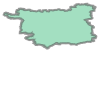

In [356]:
leeds_area = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=10)
leeds_polygon = leeds_area['geometry'][0]
leeds_polygon

In [357]:
largest_cc = max(nx.strongly_connected_components(leeds_graph), key=len)
cc_subgraph = leeds_graph.subgraph(largest_cc)

# calculate the spatial diameter of the network
diameter = nx.diameter(cc_subgraph)

stats = osmnx.basic_stats(cc_subgraph)

# extract the average street length, node density, intersection density, and edge density
avg_street_length = stats['street_length_avg']

dist = diameter * avg_street_length
# calculate the node density
node_density = len(cc_subgraph.nodes()) / (dist / 1000)**2

# calculate the intersection density
intersection_density = len([n for n in cc_subgraph.nodes() if 
                            cc_subgraph.degree(n) > 2]) / (dist / 1000)**2

# calculate the edge density
edge_density = len(cc_subgraph.edges()) / (dist / 1000)**2

# print the results
print('Spatial Diameter:', diameter)
print('Average Street Length:', avg_street_length)
print('Node Density:', node_density)
print('Intersection Density:', intersection_density)
print('Edge Density:', edge_density)

Spatial Diameter: 44
Average Street Length: 74.07214739884377
Node Density: 50.17784266704749
Intersection Density: 38.12762904344134
Edge Density: 99.69668927655403


In [403]:

stats = osmnx.basic_stats(leeds_graph)
print('Average Edge Circuity:', stats['circuity_avg'])

Average Edge Circuity: 1.061645840737841


In [390]:
nx.check_planarity(leeds_graph)
osmnx.plot_graph_folium(leeds_graph)

In [361]:
is_planar, kuratowski_subgraphs = nx.check_planarity(leeds_graph, counterexample=True)
is_planar

False

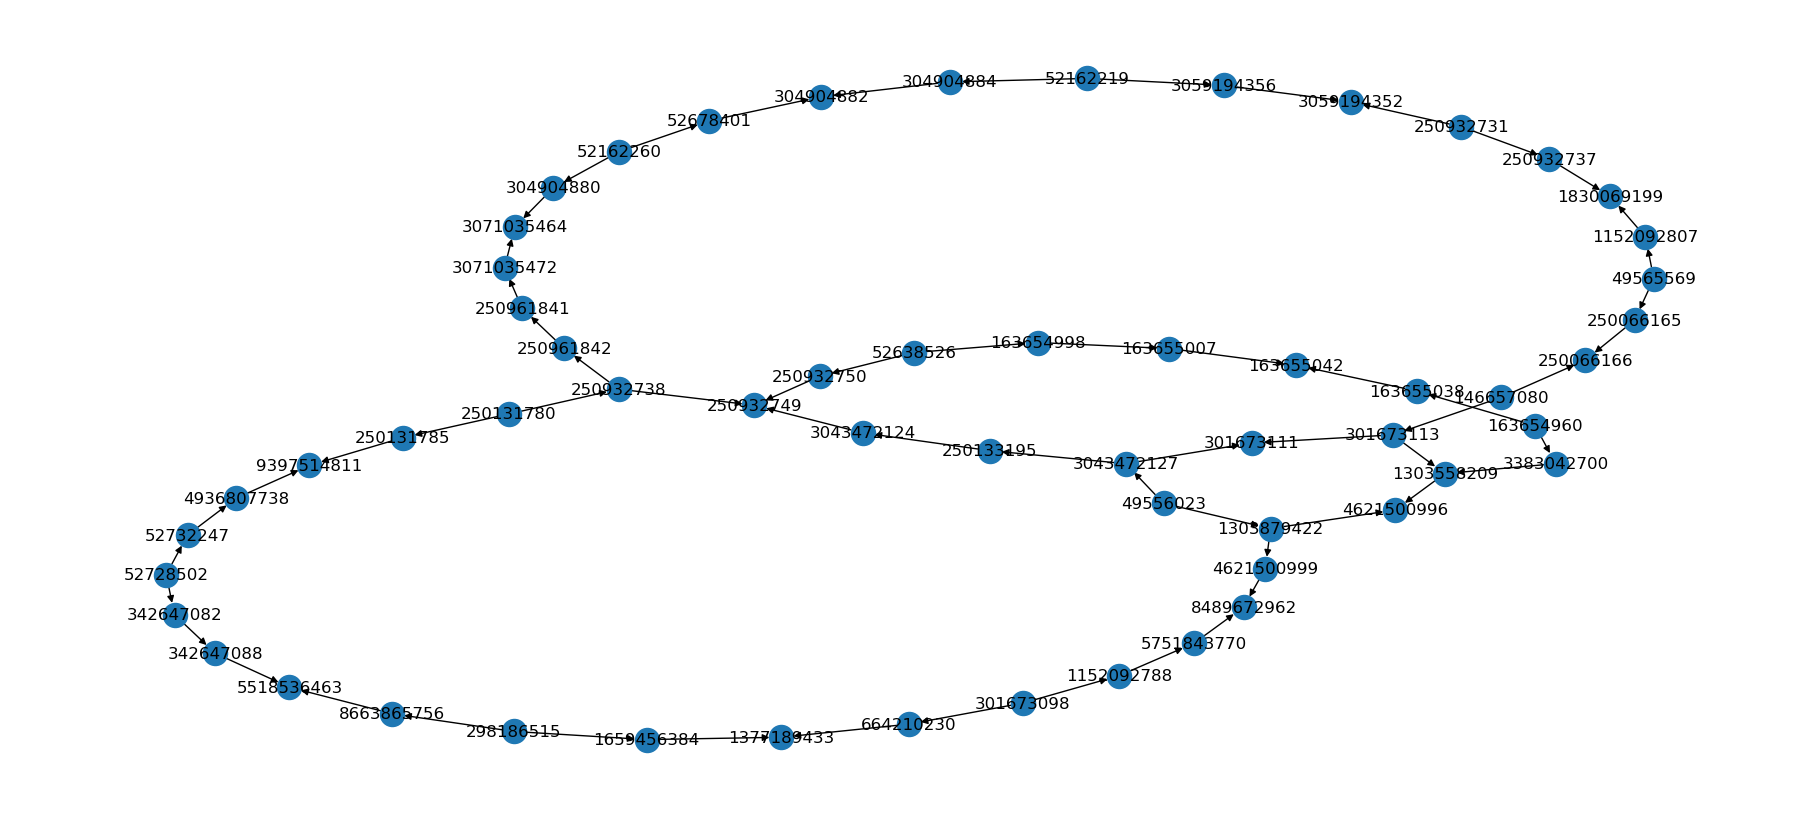

<Figure size 640x480 with 0 Axes>

In [391]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
plt.show()
plt.savefig('kuratowski_subgraphs.png')

In [408]:
data = pd.read_csv('Traffic accidents_2019_Leeds.csv')
df1 = pd.DataFrame(data)
data = pd.read_csv('RTC 2018_Leeds.csv')
df2 = pd.DataFrame(data)
data = pd.read_csv('2014.csv', encoding='iso-8859-1')
df3 = pd.DataFrame(data)
data = pd.read_csv('2015.csv',encoding='iso-8859-1')
df4 = pd.DataFrame(data)
leeds_accidents = pd.concat([df1, df2, df3, df4], axis=0)
leeds_accidents

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,...,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Accident Fields_Reference Number,Vehicle Fields_Reference Number,Casualty Fields_Reference Number,Casualty Veh No,Unnamed: 11
0,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,...,11,2,3,2,6,NaN,NaN,NaN,NaN,NaN
1,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,...,11,2,3,1,9,NaN,NaN,NaN,NaN,NaN
2,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,...,11,2,3,2,39,NaN,NaN,NaN,NaN,NaN
3,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,...,11,2,3,1,5,NaN,NaN,NaN,NaN,NaN
4,58F1730,436147,434957,2,15/08/2019,1812,3,A6120,1,1,...,11,2,3,2,8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,2CV1152,430942,435672,3,31-Dec-15,1908,A,NaN,Wet / Damp,Darkness: street lights present and lit,...,Taxi/Private hire car,Passenger,Slight,Female,4,NaN,NaN,NaN,NaN,NaN
2660,2CV1424,431965,435834,2,31-Dec-15,2208,A,NaN,Dry,Darkness: street lights present and lit,...,Car,Driver/Rider,Slight,Female,23,NaN,NaN,NaN,NaN,NaN
2661,2CV1424,431965,435834,2,31-Dec-15,2208,A,NaN,Dry,Darkness: street lights present and lit,...,Car,Passenger,Slight,Female,23,NaN,NaN,NaN,NaN,NaN
2662,31F0582,430278,434811,1,27-Nov-15,1600,Unclassified,NaN,Dry,Darkness: street lights present and lit,...,Car,Pedestrian,Slight,Female,76,NaN,NaN,NaN,NaN,NaN


In [415]:
# create a transformer object to convert from BNG to WGS84
transformer = pyproj.Transformer.from_crs('EPSG:27700', 'EPSG:4326')

# apply the transformation to the easting and northing columns of the DataFrame
leeds_accidents['Latitude'], leeds_accidents['Longitude'] = transformer.transform(leeds_accidents['Grid Ref: Easting'].values, leeds_accidents['Grid Ref: Northing'].values)
leeds_accidents["coordinates"] = list(zip(leeds_accidents["Latitude"], leeds_accidents["Longitude"]))
accidents = leeds_accidents

In [125]:
leeds_accidents_points = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(leeds_accidents.Longitude, leeds_accidents.Latitude)])
len(leeds_accidents_points)

9099

In [126]:
leeds_area = osmnx.project_gdf(leeds_area).unary_union.area
osmnx.basic_stats(leeds_graph, area=leeds_area)

{'n': 688,
 'm': 1335,
 'k_avg': 3.880813953488372,
 'edge_length_total': 97385.41300000002,
 'edge_length_avg': 72.94787490636705,
 'streets_per_node_avg': 2.7223837209302326,
 'streets_per_node_counts': {0: 0, 1: 124, 2: 26, 3: 461, 4: 71, 5: 6},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.18023255813953487,
  2: 0.0377906976744186,
  3: 0.6700581395348837,
  4: 0.10319767441860465,
  5: 0.00872093023255814},
 'intersection_count': 564,
 'street_length_total': 66997.2469999999,
 'street_segment_count': 902,
 'street_length_avg': 74.27632705099768,
 'circuity_avg': 1.0598646264045137,
 'self_loop_proportion': 0.0022172949002217295,
 'node_density_km': 1.2432310224349918,
 'intersection_density_km': 1.0191603149031039,
 'edge_density_km': 175.97756769512205,
 'street_density_km': 121.06548820950519}

In [127]:
# leeds_accidents = leeds_accidents[leeds_accidents_points.geometry.within(leeds_polygon)]
# len(leeds_accidents)
leeds_graph_with_geo = list(leeds_graph.edges(data=True))
x_vals = nx.get_node_attributes(leeds_graph,'x')
y_vals = nx.get_node_attributes(leeds_graph,'y')

for e in leeds_graph_with_geo:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_vals[e[0]], y_vals[e[0]]),
            Point(x_vals[e[1]], y_vals[e[1]])
        ])
        
road_lines = [x[2] for x in leeds_graph_with_geo]
roads_geodf = gpd.GeoDataFrame(pd.DataFrame(road_lines))

In [128]:
len(road_lines)

1335

In [129]:
leeds_points_graph = spaghetti.Network(in_data=roads_geodf)

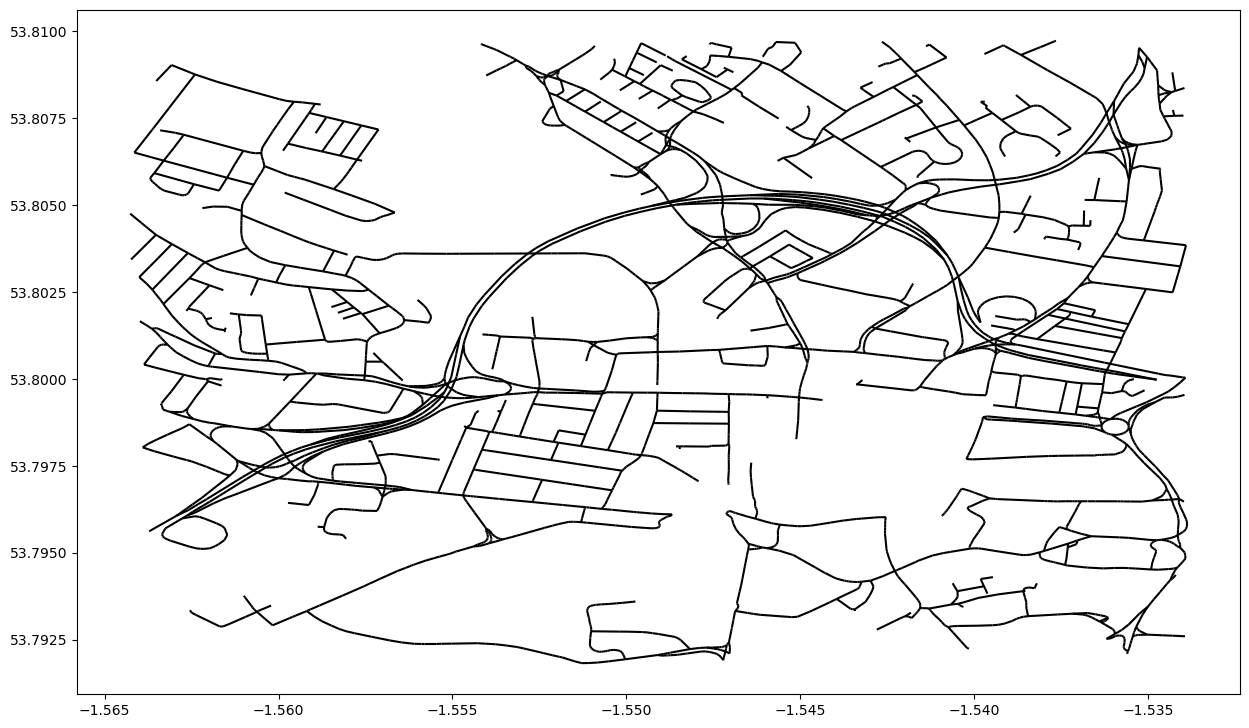

In [383]:
nodes_df, edges_df = spaghetti.element_as_gdf(leeds_points_graph,
                                             vertices=True, arcs = True)
base_network = edges_df.plot(color='k', zorder=0, figsize=(15,15))
# nodes_df.plot(ax=base_network, color='r', zorder=2)
len(nodes_df)
plt.savefig('basenetwork.png')

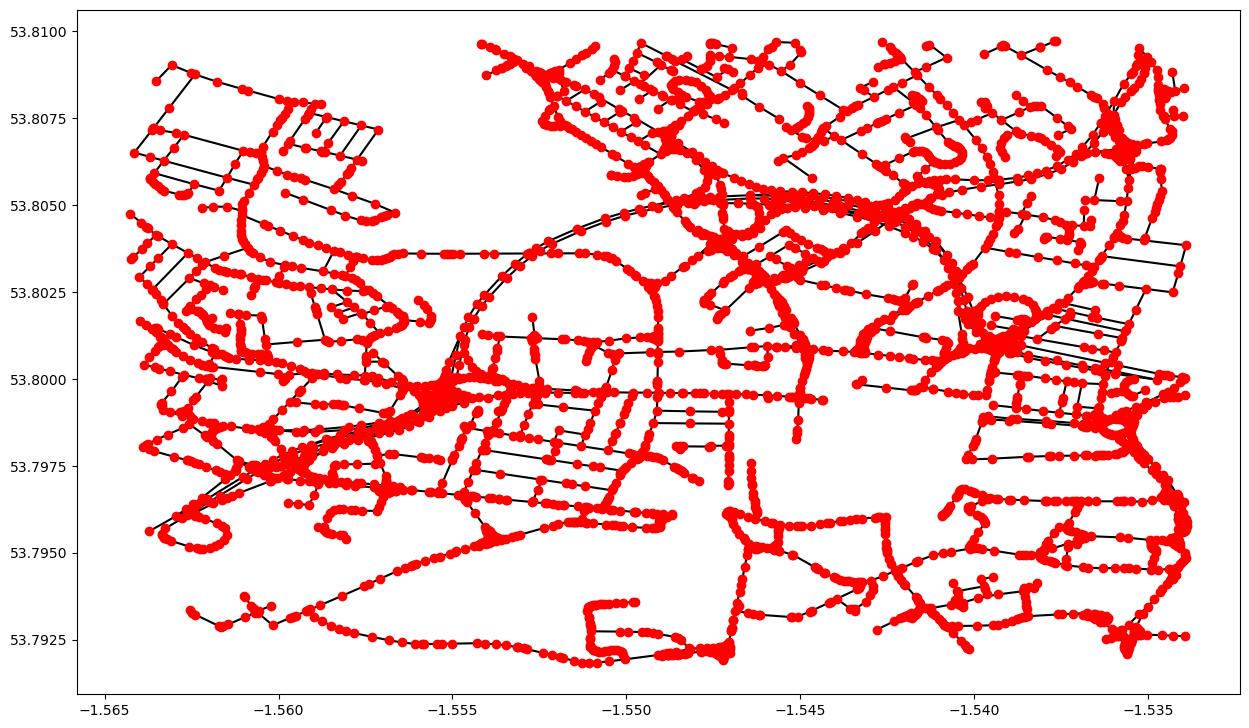

In [384]:
base_network = edges_df.plot(color='k', zorder=0, figsize=(15,15))
nodes_df.plot(ax=base_network, color='r', zorder=2)
plt.savefig('leeds_nodes.png')

In [132]:
leeds_accidents = leeds_accidents_points[leeds_accidents_points.geometry.within(leeds_polygon)]
len(leeds_accidents)

9099

/Users/muhammadkamdar/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/muhammadkamdar/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/muhammadkamdar/opt/anaconda3/lib/python3.9/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


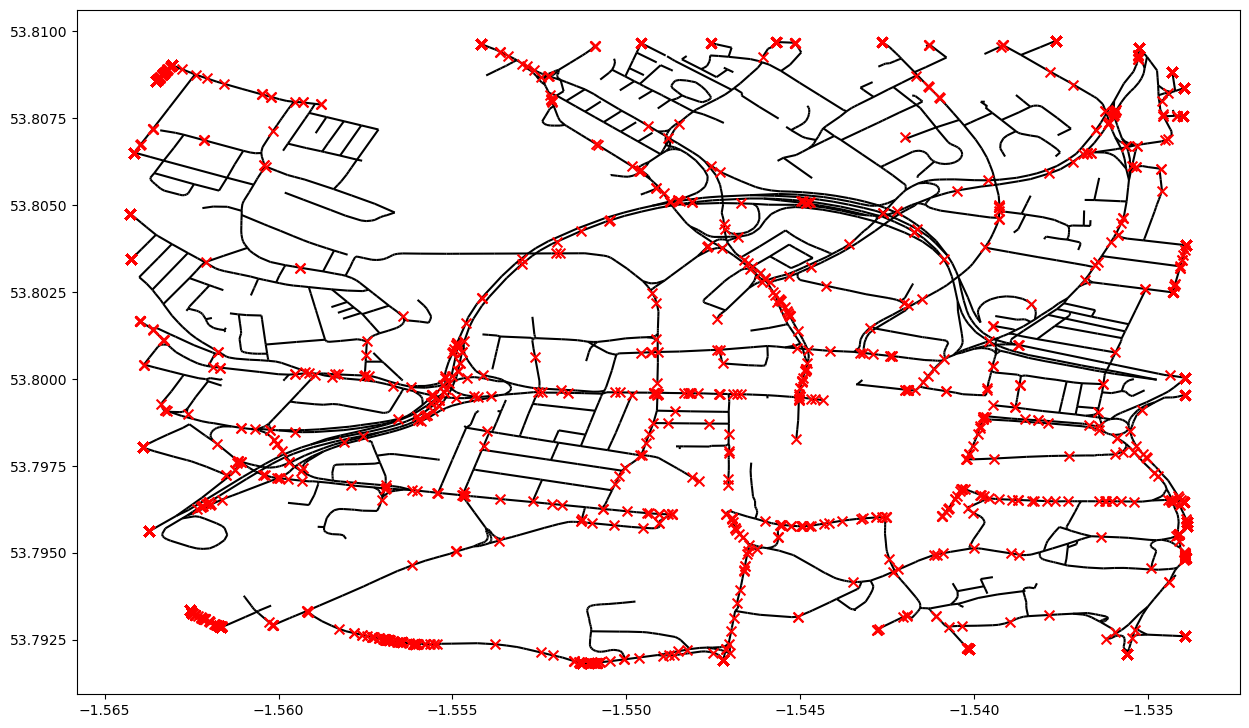

<Figure size 640x480 with 0 Axes>

In [385]:
leeds_points_graph.snapobservations(leeds_accidents, 'accidents')
base_network = edges_df.plot(color='k', zorder=0, figsize=(15,15))
snapped_accidents = spaghetti.element_as_gdf(leeds_points_graph
                                            , pp_name='accidents', snapped=True)
snapped_accidents.plot(color='r', marker='x',markersize=50, zorder=1, ax=base_network)
plt.show()
plt.savefig('leeds accidents.png')

In [428]:
G = nx.Graph(leeds_graph)

accident_counts = {}

# Loop through each accident and find the nearest road segment in the road network
for _, row in leeds_accidents.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    
    # Find the nearest node in the road network
    node, distance = nx.closest_node(leeds_graph, (lon, lat))
    
    # Get the nearest road segment to the accident location
    nearest_edge = None
    min_distance = np.inf
    for u, v, d in leeds_graph.edges(data=True):
        if node in (u, v):
            # Calculate the distance from the accident location to this road segment
            point = (lon, lat)
            line = [(leeds_graph.nodes[u]['x'], leeds_graph.nodes[u]['y']), 
                    (leeds_graph.nodes[v]['x'], leeds_graph.nodes[v]['y'])]
            dist = np.abs(np.cross(np.array(line[1]) - np.array(line[0]), np.array(line[0]) - np.array(point))) \
                   / np.linalg.norm(np.array(line[1]) - np.array(line[0]))
            
            if dist < min_distance:
                min_distance = dist
                if node == u:
                    nearest_edge = (u, v)
                else:
                    nearest_edge = (v, u)
    
    # Increment the accident count for the nearest road segment
    if nearest_edge in accident_counts:
        accident_counts[nearest_edge] += 1
    else:
        accident_counts[nearest_edge] = 1



AttributeError: module networkx has no attribute closest_node

In [47]:
# leeds_graph2 = osmnx.graph_from_place(PLACE_OF_INTEREST, dist=distance, network_type='drive')

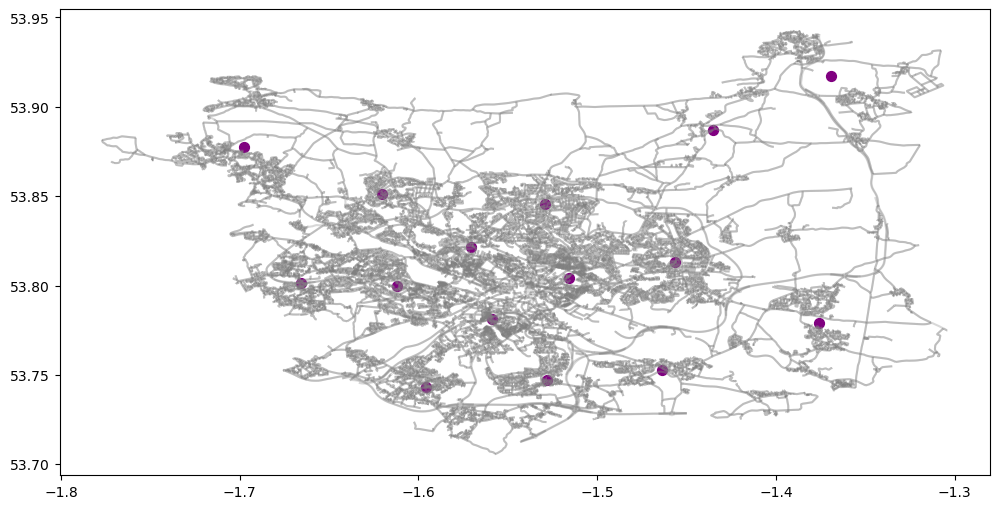

<Figure size 640x480 with 0 Axes>

In [382]:
location = 'Leeds, UK'
radius = 1000  # meters

# Download the road network for the specified location and extract the driving roads
leeds = osmnx.graph_from_place(location, network_type='drive')
leeds_gdf = osmnx.graph_to_gdfs(leeds, nodes=False)
# Create a GeoDataFrame of the nodes in the road network
nodes = osmnx.graph_to_gdfs(leeds, edges=False, node_geometry=True)

# Generate the 10 seed points using k-means clustering
n_seeds = 15
X = np.array(nodes[['y', 'x']])
kmeans = KMeans(n_clusters=n_seeds, random_state=0).fit(X)
seeds = kmeans.cluster_centers_

# Create a GeoDataFrame of the seed points
seeds_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(seeds[:, 1], seeds[:, 0]))
fig, ax = plt.subplots(figsize=(12, 12))
leeds_gdf.plot(ax=ax, alpha=0.3, color='grey')
seeds_gdf.plot(ax=ax, color='purple', markersize=50)
plt.show()
plt.savefig('seeds.png')


In [370]:
all_nodes = list(leeds.nodes)
seeds = random.choices(all_nodes, k=10)
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds, seed, weight='length') for seed in seeds}


/Users/muhammadkamdar/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


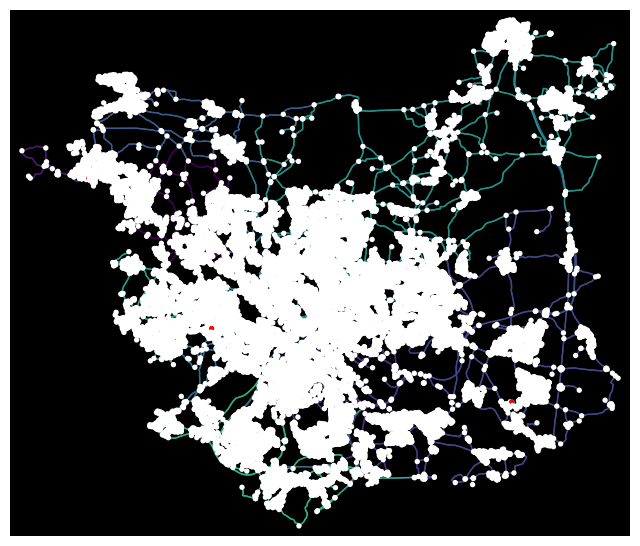

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [381]:
def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None
def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)
def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)
colours = osmnx.plot.get_colors(n_seeds)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
osmnx.plot.plot_graph(leeds, edge_color = edge_colours, node_color = node_colours, bgcolor = 'k', save = True, filepath = 'nvd.png')

In [282]:
print(seeds)
print(seeds_gdf)

[[53.84588726 -1.61189192]
 [53.77789376 -1.37789173]
 [53.82367418 -1.52430592]
 [53.80015579 -1.57484345]
 [53.91293791 -1.38208603]
 [53.87661836 -1.69683889]
 [53.74541359 -1.59272864]
 [53.80673819 -1.45775026]
 [53.80181169 -1.65482625]
 [53.75604451 -1.52201196]]
                    geometry
0  POINT (-1.61189 53.84589)
1  POINT (-1.37789 53.77789)
2  POINT (-1.52431 53.82367)
3  POINT (-1.57484 53.80016)
4  POINT (-1.38209 53.91294)
5  POINT (-1.69684 53.87662)
6  POINT (-1.59273 53.74541)
7  POINT (-1.45775 53.80674)
8  POINT (-1.65483 53.80181)
9  POINT (-1.52201 53.75604)


TASK C

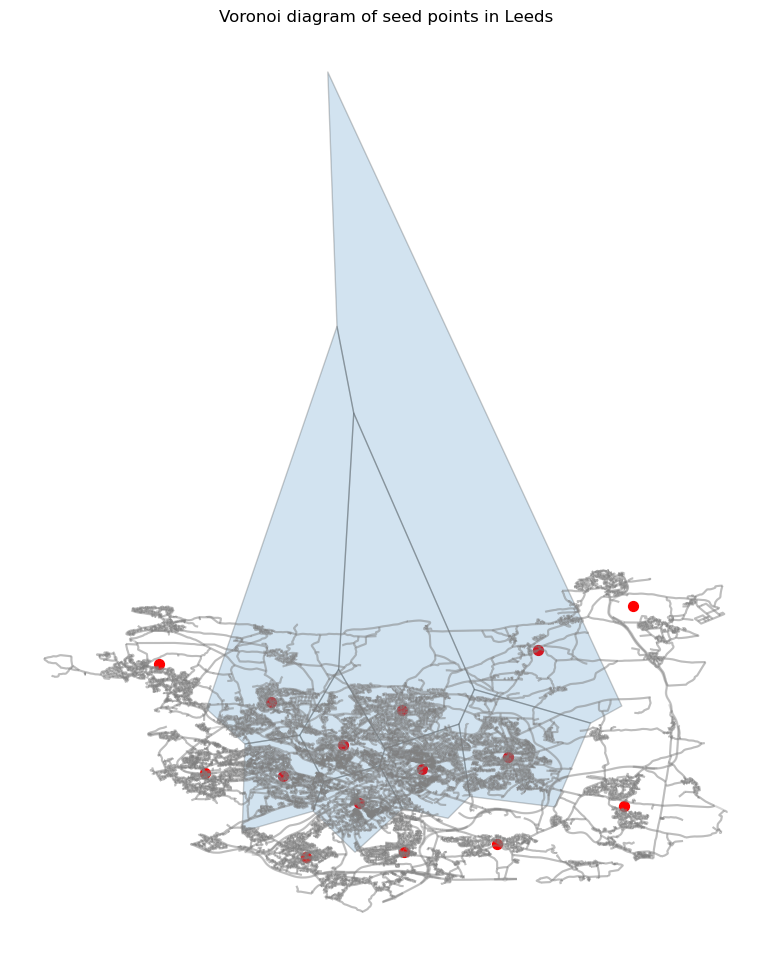

<Figure size 640x480 with 0 Axes>

In [386]:
from scipy.spatial import Voronoi, voronoi_plot_2d

# Convert the seed points to a numpy array
seeds_arr = np.array(seeds_gdf.geometry.apply(lambda p: [p.x, p.y]).tolist())

# Generate the Voronoi diagram
vor = Voronoi(seeds_arr)

# Create a GeoDataFrame of the Voronoi polygons
polygons = []
for region in vor.regions:
    if len(region) > 0 and -1 not in region:
        polygons.append(Polygon(vor.vertices[region]))
voronoi_gdf = gpd.GeoDataFrame(geometry=polygons)


# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(12, 12))
leeds_gdf.plot(ax=ax, alpha=0.3, color='grey')
seeds_gdf.plot(ax=ax, color='red', markersize=50)
voronoi_gdf.plot(ax=ax, alpha=0.2, edgecolor='black')
plt.title('Voronoi diagram of seed points in Leeds')
plt.axis('off')
plt.show()
plt.savefig('voronoi_seed_polygons.png')


In [419]:
G = osmnx.graph_from_place('Leeds, UK', network_type='drive')
nodes = [osmnx.distance.nearest_nodes(G, seed) for seed in seeds]

# Calculate the Voronoi diagram using the nodes
vor = Voronoi(np.array(osmnx.utils.graph_to_gdfs(G, edges=False).loc[nodes, ['x', 'y']]))


# Function to find the shortest path of a certain length within a polygon
def find_path_in_polygon(polygon, length):
    # Get the centroid of the polygon
    centroid = Point(polygon.centroid)

    # Find the nearest node in the road network to the centroid
    node = osmnx.get_nearest_node(leeds, centroid)

    # Get the distances from the node to all other nodes in the road network
    distances = nx.shortest_path_length(leeds, node)

    # Calculate the maximum distance to a node in the polygon
    max_distance = length / 2

    # Find all nodes within the polygon that are less than the maximum distance from the centroid
    nodes_within_polygon = [n for n in G.nodes() if Point((G.nodes[n]['x'], G.nodes[n]['y'])).within(polygon.buffer(-max_distance))]

    # Calculate the distance from each node within the polygon to all other nodes within the polygon
    distances_within_polygon = {n: nx.shortest_path_length(G, n, weight='length') for n in nodes_within_polygon}

    # Find the shortest path that starts and ends within the polygon and has a length of exactly the desired length
    for start_node in nodes_within_polygon:
        for end_node in nodes_within_polygon:
            if start_node == end_node:
                continue
            try:
                path = nx.shortest_path(G, start_node, end_node, weight='length')
            except nx.NetworkXNoPath:
                continue
            if len(path) < 2:
                continue
            if abs(length - sum([distances_within_polygon[path[i]][path[i+1]] for i in range(len(path)-1)])) < 1:
                return LineString([(G.nodes[p]['x'], G.nodes[p]['y']) for p in path])
    
    # If no path is found, return None
    return None

for i, polygon in enumerate([voronoi_poly for voronoi_poly in voronoi_regions if np.isfinite(voronoi_poly.area)]):
    path = find_path_in_polygon(polygon, 42000)
    if path:
        # Plot the polygon and path
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')
        ax.plot(*polygon.exterior.xy, color='black')
        ax.plot(*path.xy, color='red')
        ax.set_title(f"Cell {i+1}")
        plt.show()


TypeError: nearest_nodes() missing 1 required positional argument: 'Y'

In [248]:
# Create a graph of the road network in Leeds
G = nx.Graph(leeds_graph)
leeds_cells = []
for rv in vor.ridge_vertices:
    if -1 not in rv:
        leeds_cells.append([vor.vertices[rv[0]], vor.vertices[rv[1]]])



# Convert the cells into polygons using shapely library and find their centroids as the starting point
centroids = []
for cell in leeds_cells:
    cell = np.concatenate(cell, axis=0)
    print(cell)
    polygon = Polygon(cell)
    centroid = polygon.centroid
    centroids.append(centroid)

# Find the 42 km paths from each centroid and visualize them
# Find the 42 km paths from each centroid and visualize them
# for centroid in centroids:
#     paths = []
#     for node in G.nodes():
#         path_length = nx.shortest_path_length(G, centroid.coords[0], node, weight='length')
#         if path_length == 42000:
#             path = nx.shortest_path(G, centroid.coords[0], node, weight='length')
#             paths.append(path)
#     if paths:
#         # Plot the cell polygon and found paths
#         cell = leeds_gdf[leeds_gdf.geometry.contains(centroid)].iloc[0]['geometry']
#         fig, ax = plt.subplots()
#         leeds_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
#         ax.add_patch(PolygonPatch(cell, facecolor='blue', alpha=0.5))
#         for path in paths:
#             nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, 'pos'), edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], width=3)
#         ax.set_title('Cell with 42 km path(s)')
#         plt.show()


[-1.39885327 53.84482993 -1.47050044 53.89587647]


ValueError: linearrings: Input operand 0 does not have enough dimensions (has 1, gufunc core with signature (i, d)->() requires 2)

In [320]:
# Define a function to find the nearest node in the road network to a given point
def get_nearest_node(G, point):
    nodes = ox.distance.nearest_nodes(G, point.x, point.y)
    return nodes 


# Find the nearest nodes in the road network to the Voronoi cell centroids
cells = []
for i in range(len(voronoi_gdf)):
    cell = voronoi_gdf.iloc[i].geometry
    node = get_nearest_node(leeds, cell.centroid)
    cells.append({'cell': cell, 'node': node})

# Define a function to find paths of a given length that start and end at the same node
def find_circular_paths(G, node, path_length):
    circular_paths = []
    for path in nx.all_simple_paths(G, node, node):
        if len(path) > 1 and len(path) * 25 == path_length:
            circular_paths.append(path)
    return circular_paths

# Find the Voronoi cells that are at least 42 km^2 in area
cells_42_km = []
for cell in cells:
    if cell['cell'].area >= 42e6:
        cells_42_km.append(cell)

# Find circular paths of length 42 km in each of the selected Voronoi cells
circular_paths = []
for cell in cells_42_km:
    node = cell['node']
    paths = find_circular_paths(leeds, node, 42000)
    if len(paths) > 0:
        circular_paths.append({'cell': cell['cell'], 'node': node, 'paths': paths})

# Select 2 or 3 cells for which we can find a circular path of 42 km
selected_cells = circular_paths[:3]

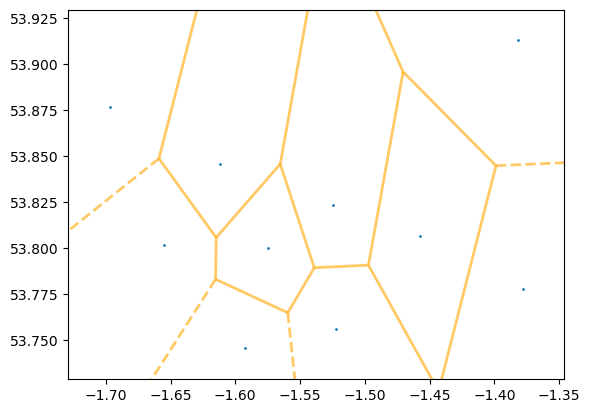

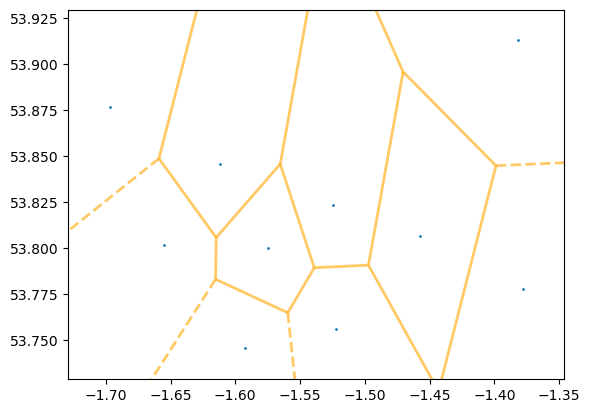

In [256]:
voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=2, 
                show_points=True, ax=None, s=None, add_points=None,
                return_fig=False)

In [321]:
print(selected_cells)

[]


In [324]:
voronoi_gdf

,geometry
0,"POLYGON ((-1.39892 53.83645, -1.37731 53.84833..."
1,"POLYGON ((-1.49004 53.83574, -1.47937 53.85976..."
2,"POLYGON ((-1.48258 53.78567, -1.42358 53.77844..."
3,"POLYGON ((-1.60024 53.82804, -1.57332 53.87370..."
4,"POLYGON ((-1.58364 53.79599, -1.60024 53.82804..."
5,"POLYGON ((-1.58364 53.79599, -1.60024 53.82804..."
6,"POLYGON ((-1.52901 53.77723, -1.54499 53.80687..."
7,"POLYGON ((-1.56196 53.74702, -1.59094 53.77551..."
